In [5]:
!pip install pylidc

In [6]:
!rm /root/.pylidcrc
!touch /root/.pylidcrc
!echo [dicom] >> /root/.pylidcrc
!echo path = /kaggle/input/lidcidri/LIDC-IDRI/LIDC-IDRI-0001 >> /root/.pylidcrc
!echo warn = True >> /root/.pylidcrc

In [1]:
import os, math, glob, re
import numpy as np
import pandas as pd
import cv2

import matplotlib.pyplot as plt
import pydicom

from sklearn.model_selection import train_test_split

from random import shuffle
import tensorflow as tf

import pylidc as pl
from pylidc.utils import consensus

import random
import shutil
from scipy import ndimage

In [2]:
patients = pd.read_csv("LIDC-IDRI/LIDC-IDRI_MetaData.csv")
patients.rename(columns={"Number of images": "num_images"}, inplace=True)
patients["id"] = patients['Subject ID'].apply(lambda x : x[-4: ]).astype(int)
patients = patients.query("num_images > 50")
patients = patients.reset_index(drop=True)

In [3]:
for i, duplicate in enumerate(patients.duplicated('Subject ID')):
    if duplicate:
        print(i, patients.iloc[i]['Subject ID'])
        patients.loc[i, 'Subject ID'] = patients.loc[i, 'Subject ID'] + "-2"

155 LIDC-IDRI-0484
231 LIDC-IDRI-0355
523 LIDC-IDRI-0132
722 LIDC-IDRI-0332
776 LIDC-IDRI-0442
818 LIDC-IDRI-0315
939 LIDC-IDRI-0151
953 LIDC-IDRI-0365


In [4]:
for x in patients['Subject ID']:
    if x[-2:] == "-2":
        print(x)

LIDC-IDRI-0484-2
LIDC-IDRI-0355-2
LIDC-IDRI-0132-2
LIDC-IDRI-0332-2
LIDC-IDRI-0442-2
LIDC-IDRI-0315-2
LIDC-IDRI-0151-2
LIDC-IDRI-0365-2


In [5]:
X_train, X_val, y_train, y_val = train_test_split(patients, 
                                                  patients['Subject ID'], 
                                                  test_size=0.2, 
                                                  random_state=42,
                                                  )

In [6]:
train_ids = y_train
val_ids = y_val

train_ids = train_ids.sort_values(ascending=True).reset_index(drop=True)
val_ids = val_ids.sort_values(ascending=True).reset_index(drop=True)
print(f"{len(train_ids)} Train Scans")
print(f"{len(val_ids)} Val Scans")

814 Train Scans
204 Val Scans


In [7]:
def getBoxSize(bbox, size):
     return [getSide(b, size) for b in bbox[0:2]]

def getSide(box, size):
    xl = box[0] - 0
    xr = 511 - box[1]
    fillx = size - (box[1] - box[0] + 1)
    if fillx <= 0:
        return (int(0), int(0))
    if xl < fillx/2:
        x1 = xl
        x2 = fillx - xl
    elif xr < fillx/2:
        x2 = xr
        x1 = fillx - xr
    else:
        x1 = int(fillx/2)
        x2 = fillx - x1
    
    return (int(x1), int(x2))

In [8]:
local_directory = "LIDC-IDRI/"

MIN_BOUND = -1000.0
MAX_BOUND = 400.0
IMAGE_SIZE = 512
BBOX_SIZE = 64

def load_dicom_img(path, img_size=512):

    dicom = pydicom.read_file(path)
    data = dicom.pixel_array
    data = cv2.resize(data, (img_size, img_size))
    
    return data

def load_scan(path):
    slices = [pydicom.read_file(path + '/' + s) for s in os.listdir(path) if s[-3:] == "dcm"]
    slices.sort(key = lambda x: float(x.ImagePositionPatient[2]))
    try:
        slice_thickness = np.abs(slices[0].ImagePositionPatient[2] - slices[1].ImagePositionPatient[2])
    except:
        slice_thickness = np.abs(slices[0].SliceLocation - slices[1].SliceLocation)
        
    for s in slices:
        s.SliceThickness = slice_thickness
        
    return slices
    
# def normalize(image):
#     image = (image - MIN_BOUND) / (MAX_BOUND - MIN_BOUND)
#     image[image>1] = 1.
#     image[image<0] = 0.
#     return image

# PIXEL_MEAN = 0.25

# def zero_center(image):
#     image = image - PIXEL_MEAN
#     return image

def load_mask3(scan_id):
    if scan_id[-2:] == '-2':
        scan = pl.query(pl.Scan).filter(pl.Scan.patient_id == scan_id[:-2])[1]
    else:
        scan = pl.query(pl.Scan).filter(pl.Scan.patient_id == scan_id).first()
    nods = scan.cluster_annotations()
#     masks = np.zeros((num_files, 512, 512))
    
    frames = []
    bbox_matrix = []
#     tumors = []
#     masks = []
    malignancy = []
    
    internalStructure = []
    calcification = []
    sphericity = []
    margin = []
    lobulation = []
    spiculation = []
    texture = []

    if len(nods) > 0:
        for nod in nods:
            annotation = nod[0]
#             volume = annotation.scan.to_volume()
            slices = annotation.contour_slice_indices
#             tumor = volume[annotation.bbox()].transpose(2, 0, 1)
#             tumor = [cv2.resize(img, (64, 64)) for img in tumor]
#             mask = annotation.boolean_mask().astype(np.uint8).transpose(2, 0, 1)
#             mask = np.array([cv2.resize(img, (64, 64)) for img in mask])
            bbox = annotation.bbox_matrix()
            padding = getBoxSize(bbox, BBOX_SIZE)
            padding.append((0,0))

            bbox = annotation.bbox(pad=padding)
            
            bbox_matrix.append(bbox)
            
            
            internalStructure.append(annotation.internalStructure)
            calcification.append(annotation.calcification)
            sphericity.append(annotation.sphericity)
            margin.append(annotation.margin)
            lobulation.append(annotation.lobulation)
            spiculation.append(annotation.spiculation)
            texture.append(annotation.texture)
            malignancy.append(annotation.malignancy)
            
            # Create (N, 512, 512) Boolean Array with segmentation mask data
#             cmask, cbbox, masks2 = consensus(annotations, pad=IMAGE_SIZE)
#             print(type(cmask), type(cbbox), type(masks2))
#             masks += consensus(annotations, pad=IMAGE_SIZE)[0].transpose(2, 0, 1)

            # Get slice (start, end) indices of where annotations exist
#             consensus_data = consensus(annotations)[1]
#             start_index, stop_index = consensus_data[2].start, consensus_data[2].stop
#             print(start_index, stop_index)      
            
            
            frames.append(slices)
#             tumors.append(tumor)
#             masks.append(mask)
#         masks = np.zeros((num_files, 512, 512))
#         start_index = 0
#         stop_index = 0
#         frames += [i for i in range(start_index, stop_index)]
    
#     frames = list(set(frames))
    
    return frames, bbox_matrix, malignancy, internalStructure, calcification, sphericity, margin, lobulation, spiculation, texture

def get_pixels_hu(slices, img_size=512):
    try:
        image = np.stack([cv2.resize(s.pixel_array, (img_size, img_size)) for s in slices])
    except:
        image = np.stack([s for s in slices])
    # Convert to int16 (from sometimes int16), 
    # should be possible as values should always be low enough (<32k)
    image = image.astype(np.int16)

    # Set outside-of-scan pixels to 0
    # The intercept is usually -1024, so air is approximately 0
#     image[image == -2000] = 0
    
    # Convert to Hounsfield units (HU)
    for slice_number in range(len(slices)):
        
        intercept = slices[slice_number].RescaleIntercept
        slope = slices[slice_number].RescaleSlope
        
        if slope != 1:
            image[slice_number] = slope * image[slice_number].astype(np.float64)
            image[slice_number] = image[slice_number].astype(np.int16)
            
        image[slice_number] += np.int16(intercept)
        
    # Make all pixel values positive
#     image += 2048
    
    return np.array(image, dtype=np.int16)

def get_tumor_bbox(img3d, bbox):
#     C, W, H --> original
#     W, H, C --> transposed
#     W, H, C --> bbox
    tumors = img3d.transpose(1, 2, 0)[bbox]#[bbox[0][0]:bbox[0][1] + 1, bbox[1][0]:bbox[1][1] + 1, bbox[2][0]:bbox[2][1] + 1]
#     tumors = img3d[bbox[2][0]:bbox[2][1] + 1, bbox[0][0]:bbox[0][1] + 1, bbox[1][0]:bbox[1][1] + 1]
#     img3d.transpose(1, 2, 0)[bbox[2][0]:bbox[2][1] + 1,  bbox[1][0]:bbox[1][1] + 1, bbox[0][0]:bbox[0][1] + 1]
    if tumors.shape[0] != BBOX_SIZE or tumors.shape[1] != BBOX_SIZE:
        tumor_array = []
        for i in range(tumors.shape[-1]):
            tumor_array.append(cv2.resize(tumors[..., i], (BBOX_SIZE, BBOX_SIZE)))
        tumors = np.array(tumor_array)
    else:
        tumors = tumors.transpose(2, 0, 1)
    
    tumors = resize_volume(tumors)
    return tumors

def normalize(volume):
    """Normalize the volume"""
    min = -1000
    max = 400
    volume[volume < min] = min
    volume[volume > max] = max
    volume = (volume - min) / (max - min)
    return volume


def resize_volume(img):
    """Resize across z-axis"""
    # Set the desired depth
    desired_depth = 32
    desired_width = 64
    desired_height = 64
    # Get current depth
    current_depth = img.shape[0]
    current_width = img.shape[1]
    current_height = img.shape[2]
    # Compute depth factor
    depth = current_depth / desired_depth
    width = current_width / desired_width
    height = current_height / desired_height
    depth_factor = 1 / depth
    width_factor = 1 / width
    height_factor = 1 / height
    # Rotate
    # img = ndimage.rotate(img, 90, reshape=False)
    # Resize across z-axis
    img = ndimage.zoom(img, (depth_factor, width_factor, height_factor), order=1)
    return img

def load_dicom_scan2(scan_id):
#     files = sorted([y for x in os.walk(f"{local_directory}/{scan_id}") for y in tf.io.gfile.glob(os.path.join(x[0], '*.dcm'))])
               #key=lambda var:[int(x) if x.isdigit() else x for x in re.findall(r'[^0-9]|[0-9]+', var)])
    scan_dir = os.path.join(local_directory, scan_id)    
    num_files = len(tf.io.gfile.glob(os.path.join(scan_dir, '*.dcm')))
    
    if scan_id[-2:] == '-2':
        scan = pl.query(pl.Scan).filter(pl.Scan.patient_id == scan_id[:-2])[1]
    else:
        scan = pl.query(pl.Scan).filter(pl.Scan.patient_id == scan_id).first()
            
    img_slices = load_scan(scan_dir)
    img3d = get_pixels_hu(img_slices)
#     img3d = zero_center(normalize(img3d))
    img3d = normalize(np.array(img3d))

#     nodules = []
#     nods = scan.cluster_annotations()
#     for nod in nods:
#         for ann in nod:
#             nodule = img3d[ann.bbox()]
#             nodules.append(nodule)
    
    
#     masks, start_index, stop_index = load_mask2(scan_id, num_files)
    frames, bbox_matrix, malignancy, internalStructure, calcification, sphericity, margin, lobulation, spiculation, texture = load_mask3(scan_id)

    tumors = [get_tumor_bbox(img3d, bbox) for bbox in bbox_matrix]
    
    # for i, tumor in enumerate(tumors):
    #     num_images_required = 32 - tumor.shape[0]
    #     if num_images_required > 0:
    #         tumors[i] = np.concatenate([tumor, np.full((num_images_required, tumor.shape[1], tumor.shape[2]), fill_value=-2048)], axis=0)
    #     elif num_images_required < 0:
    #         tumors[i] = tumor[:32]
    #         frames[i] = frames[i][:32]
        
    tumors = np.array(tumors).astype(np.float32)
    # frames = np.array(frames).astype(np.int64)
    malignancy = np.array(malignancy).astype(np.int64)
    internalStructure = np.array(internalStructure).astype(np.int64)
    calcification = np.array(calcification).astype(np.int64)
    sphericity = np.array(sphericity).astype(np.int64)
    margin = np.array(margin).astype(np.int64)
    lobulation = np.array(lobulation).astype(np.int64)
    spiculation = np.array(spiculation).astype(np.int64)
    texture = np.array(texture).astype(np.int64)
#     tumors = [get_pixels_hu(tumor) for tumor in tumors]

#     annotation_indices = [i for i in range(start_index, stop_index)]
#     annotation_indices = frames
#     random_samples_indices = None
    
#     if slice==True:
#         random_sample_list = [i for i in range(0, num_files) if i not in annotation_indices]
#         random_samples_indices = random.sample(random_sample_list, min(len(random_sample_list), img_depth - len(annotation_indices)))
#         random_samples_indices.extend(annotation_indices)
#         random_samples_indices.sort()
        
#         num_files_middle = num_files//2
#         img_depth_middle = img_depth//2

#         start_depth = max(0, num_files_middle - img_depth_middle)
#         end_depth   = min(num_files, num_files_middle + img_depth_middle)
#     else:
#         start_depth = 0
#         end_depth = num_files
                
#     img3d = img3d[random_samples_indices, :, :]
#     masks = masks[random_samples_indices, :, :]
#     img3d = np.stack([load_dicom_img(dicom_img, img_size=img_size) 
#                       for dicom_img in files[start_depth:end_depth]], axis=2)#.T

#     if slice==True and img3d.shape[0] < img_depth:
#         n_zero = np.zeros((img_depth - img3d.shape[0], img_size, img_size))
#         img3d  = np.concatenate((img3d, n_zero), axis=0)
#         masks = np.concatenate((masks, n_zero), axis=0)
        
#     annotated_indices_new = [random_samples_indices.index(ind) for ind in annotation_indices]
        
    return frames, tumors, malignancy, internalStructure, calcification, sphericity, margin, lobulation, spiculation, texture

In [36]:
frames, tumors, malignancy, internalStructure, calcification, sphericity, margin, lobulation, spiculation, texture = load_dicom_scan2('LIDC-IDRI-0134')
print(frames, malignancy, internalStructure, calcification, sphericity, margin, lobulation, spiculation, texture)
# index = np.where(np.asarray(random_samples_indices) == 86)[0]

[array([63, 64, 65], dtype=int64), array([66, 67, 68, 69], dtype=int64), array([75, 76], dtype=int64)] [5 5 1] [1 1 1] [6 6 3] [5 5 5] [5 5 5] [1 1 1] [1 1 1] [5 5 5]


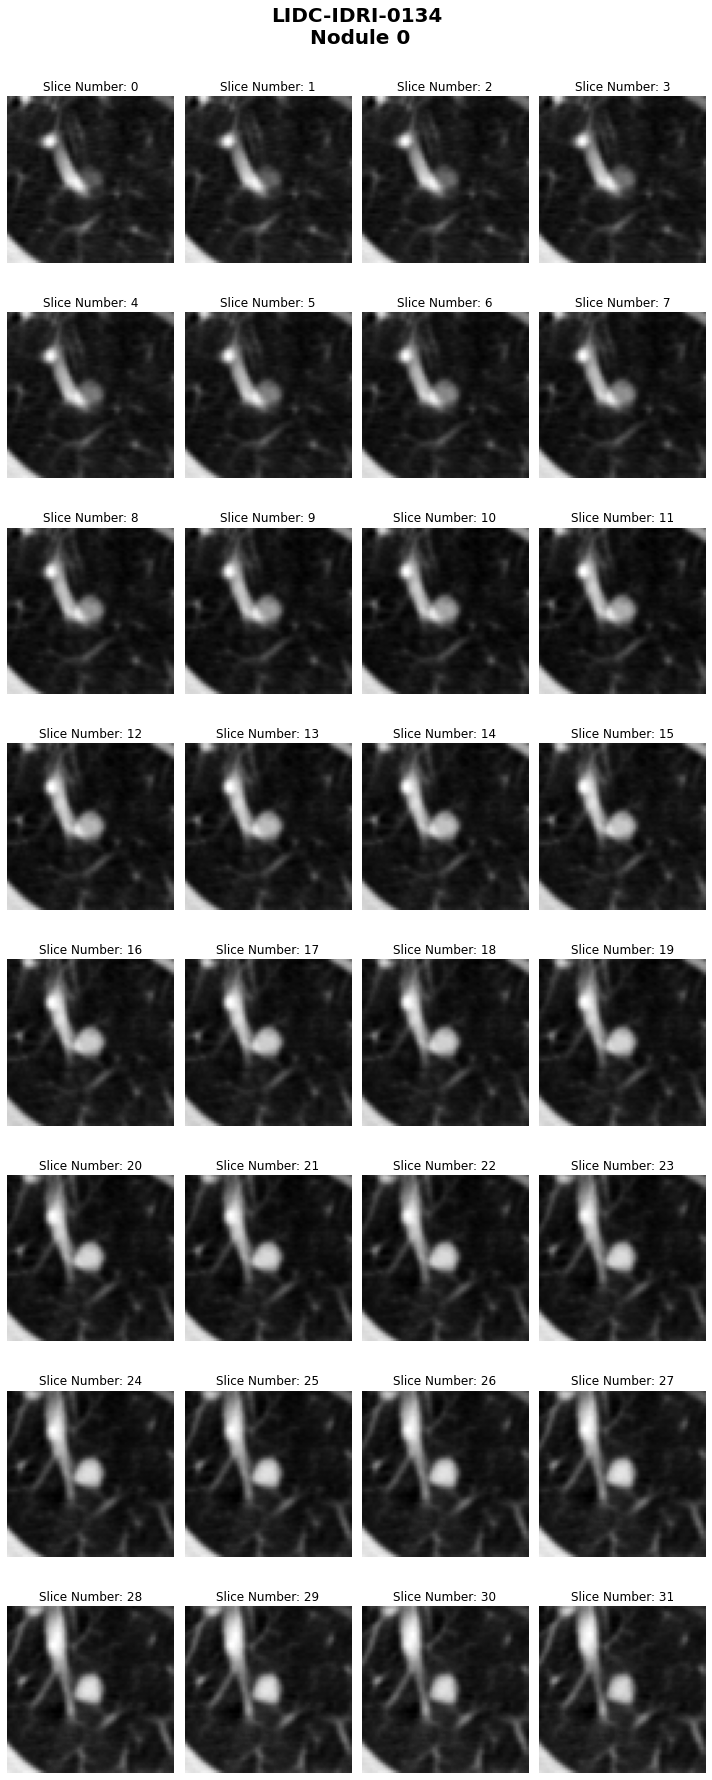

In [37]:
tumor_id = 0

ncols = 4
nrows = math.ceil(len(tumors[tumor_id]) / ncols)

f, plots = plt.subplots(nrows, ncols, figsize=(10, 25))
title = f.suptitle(f'LIDC-IDRI-0134\n Nodule {tumor_id}', fontsize='20', fontweight ="bold")

i = 0
j = 0

for index, ind in enumerate(tumors[tumor_id]):
    plots[i, j].axis('off')
    plots[i, j].set_title(f"Slice Number: {index}")
#     plots[i, j].imshow(img3d[ind], cmap=plt.cm.gray)
#     plots[i, j].imshow(masks[ind], alpha=0.5)
    plots[i, j].imshow(tumors[tumor_id][index], cmap=plt.cm.gray)
    j += 1
    if j % ncols == 0:
        i += 1
        j = 0

title.set_y(1)
f.tight_layout()
plt.savefig(f'LIDC-IDRI-0134.jpg')

In [97]:
max_length = 0
max_width = 0
max_slices = 0

lengths = []
widths = []
slice_lengths = []
count = 0

for scan_id in train_ids:
    if scan_id[-2:] == '-2':
        scan = pl.query(pl.Scan).filter(pl.Scan.patient_id == scan_id[:-2])[1]
    else:
        scan = pl.query(pl.Scan).filter(pl.Scan.patient_id == scan_id).first()
    nods = scan.cluster_annotations()
    if len(nods) > 0:
        for nod in nods:
            annotation = nod[0]
            bbox = annotation.bbox()
            length = bbox[0].stop - bbox[0].start
            width = bbox[1].stop - bbox[1].start
            slices = bbox[2].stop - bbox[2].start
            if length > 64 or width > 64:
                print(scan_id)
            max_length = max(length, max_length)
            max_width = max(width, max_width)
            max_slices = max(slices, max_slices)
            lengths.append(length)
            widths.append(width)
            slice_lengths.append(slices)
            count += 1

# print(max_length, max_width, max_slices)

Failed to reduce all groups to <= 4 Annotations.
Some nodules may be close and must be grouped manually.
Failed to reduce all groups to <= 4 Annotations.
Some nodules may be close and must be grouped manually.
Failed to reduce all groups to <= 4 Annotations.
Some nodules may be close and must be grouped manually.
Failed to reduce all groups to <= 4 Annotations.
Some nodules may be close and must be grouped manually.
LIDC-IDRI-0347
Failed to reduce all groups to <= 4 Annotations.
Some nodules may be close and must be grouped manually.
LIDC-IDRI-0415
LIDC-IDRI-0575
LIDC-IDRI-0576
Failed to reduce all groups to <= 4 Annotations.
Some nodules may be close and must be grouped manually.
LIDC-IDRI-0624
LIDC-IDRI-0701
LIDC-IDRI-0703
LIDC-IDRI-0709
Failed to reduce all groups to <= 4 Annotations.
Some nodules may be close and must be grouped manually.
LIDC-IDRI-0834
Failed to reduce all groups to <= 4 Annotations.
Some nodules may be close and must be grouped manually.
Failed to reduce all grou

In [98]:
count

2104

In [63]:
hist = pd.DataFrame(lengths).hist(bins=3)

In [64]:
hist = pd.DataFrame(widths).hist(bins=3)

In [65]:
hist = pd.DataFrame(slice_lengths).hist(bins=3)

In [31]:
plt.imshow(tumors[1][:, :, 0], plt.cm.gray)

In [ ]:
plt.imshow(img3d[86])
np.unique(img3d[86])

In [11]:
def _bytes_feature(value):
    """Returns a bytes_list from a string / byte."""
    if isinstance(value, type(tf.constant(0))):
        value = value.numpy() 
    return tf.train.Feature(bytes_list=tf.train.BytesList(value=[value]))

def _float_feature(value):
    """Returns a float_list from a float / double."""
    return tf.train.Feature(float_list=tf.train.FloatList(value=[value]))

def _int64_feature(value):
    """Returns an int64_list from a bool / enum / int / uint."""
    return tf.train.Feature(int64_list=tf.train.Int64List(value=[value]))

def _int64_feature_list(value):
    """Returns an int64_list from a bool / enum / int / uint."""
    return tf.train.Feature(int64_list=tf.train.Int64List(value=value))

In [12]:
def image_example(scan_id, frames, tumor, malignancy, internalStructure, calcification, sphericity, margin, lobulation, spiculation, texture):
    image_shape = tumor.shape
    
    scan_bytes = scan_id.encode("utf-8")

    # img_bytes = image.tobytes()
    # mask_bytes = mask.tobytes()
    
    feature = {
        'scan_id': _bytes_feature(scan_bytes),
        'height': _int64_feature(image_shape[1]),
        'width': _int64_feature(image_shape[2]),
        'num_channels': _int64_feature(image_shape[0]),
        'image': _bytes_feature(tf.io.serialize_tensor(tf.convert_to_tensor(tumor, dtype=tf.float32))),
        'label': _int64_feature(malignancy),
        'internalStructure': _int64_feature(internalStructure),
        'calcification': _int64_feature(calcification),
        'sphericity': _int64_feature(sphericity),
        'margin': _int64_feature(margin),
        'lobulation': _int64_feature(lobulation),
        'spiculation': _int64_feature(spiculation),
        'texture': _int64_feature(texture)
    }
    
    annotations = tf.train.FeatureList(feature=[_int64_feature(index) for index in frames])
    
    feature_list = {
        'annotation_indices': annotations,
    }
    
    return tf.train.SequenceExample(feature_lists=tf.train.FeatureLists(feature_list=feature_list), context=tf.train.Features(feature=feature))

In [ ]:
def write_tfrecords(scan_list, output_dir, data_split, file_index, num_files):
    output_path = f"{output_dir}/{data_split}-{file_index}-{num_files}.tfrec"
    opts = tf.io.TFRecordOptions(compression_type="GZIP")
        
    with tf.io.TFRecordWriter(output_path, opts) as writer:
        for scan_id in scan_list:
            frames, tumors, malignancy, internalStructure, calcification, sphericity, margin, lobulation, spiculation, texture = load_dicom_scan2(scan_id)
            print()
            for i in range(tumors.shape[0]):
                tf_example = image_example(scan_id, frames[i], tumors[i], malignancy[i], internalStructure[i], calcification[i], sphericity[i], margin[i], lobulation[i], spiculation[i], texture[i])            
                writer.write(tf_example.SerializeToString())
                
            print("Finished writing {}".format(scan_id))
        
        print("Finished file {}".format(f"{data_split}-{file_index}-{num_files}.tfrec"))

In [170]:
output_dir = "LIDC-IDRI-TFRecords9"
for i, pos in enumerate(range(0, len(train_ids), scans_per_file)):
    scan_list = [train_ids[ind] for ind in range(pos, min(len(train_ids), pos + scans_per_file))]
    if i == 6:
        write_tfrecords(scan_list, output_dir, "train", i, len(scan_list))

In [14]:
scans_per_file = 50

output_dir = "LIDC-IDRI-TFRecords9"
if os.path.exists(output_dir):
    shutil.rmtree(output_dir)
os.mkdir(output_dir)

In [15]:
for i, pos in enumerate(range(0, len(train_ids), scans_per_file)):
    scan_list = [train_ids[ind] for ind in range(pos, min(len(train_ids), pos + scans_per_file))]
    write_tfrecords(scan_list, output_dir, "train", i, len(scan_list))

for i, pos in enumerate(range(0, len(val_ids), scans_per_file)):
    scan_list = [val_ids[ind] for ind in range(pos, min(len(val_ids), pos + scans_per_file))]
    write_tfrecords(scan_list, output_dir, "val", i, len(scan_list))

Finished writing LIDC-IDRI-0001
Finished writing LIDC-IDRI-0002
Finished writing LIDC-IDRI-0003
Finished writing LIDC-IDRI-0004
Finished writing LIDC-IDRI-0005
Finished writing LIDC-IDRI-0006
Finished writing LIDC-IDRI-0008
Finished writing LIDC-IDRI-0009
Finished writing LIDC-IDRI-0010
Finished writing LIDC-IDRI-0011
Finished writing LIDC-IDRI-0012
Finished writing LIDC-IDRI-0013
Finished writing LIDC-IDRI-0015
Finished writing LIDC-IDRI-0016
Finished writing LIDC-IDRI-0017
Finished writing LIDC-IDRI-0018
Finished writing LIDC-IDRI-0019
Finished writing LIDC-IDRI-0020
Finished writing LIDC-IDRI-0021
Finished writing LIDC-IDRI-0023
Finished writing LIDC-IDRI-0024
Finished writing LIDC-IDRI-0025
Finished writing LIDC-IDRI-0026
Finished writing LIDC-IDRI-0030
Finished writing LIDC-IDRI-0031
Finished writing LIDC-IDRI-0033
Finished writing LIDC-IDRI-0034
Finished writing LIDC-IDRI-0036
Finished writing LIDC-IDRI-0037
Finished writing LIDC-IDRI-0038
Finished writing LIDC-IDRI-0039
Finished

In [ ]:
!ls LIDC-IDRI-TFRecords/ -ltr -h

# Verify TFRecord

In [153]:
# image_feature_description = {
#         'scan_id': _bytes_feature(scan_bytes),
#         'height': _int64_feature(image_shape[1]),
#         'width': _int64_feature(image_shape[2]),
#         'num_channels': _int64_feature(image_shape[0]),
#         'image': _bytes_feature(img_bytes),
#         'mask' : _bytes_feature(mask_bytes),
#         'annotation_indices': _int64_feature_list(annotation_indices),
#         'random_sample_indices': _int64_feature_list(random_samples_indices)
#     }

feature_description = {
    'scan_id': tf.io.FixedLenFeature([], tf.string),
    'height': tf.io.FixedLenFeature([], tf.int64),
    'width': tf.io.FixedLenFeature([], tf.int64),
    'num_channels': tf.io.FixedLenFeature([], tf.int64),
    'image': tf.io.FixedLenFeature([], tf.string),
    'label': tf.io.FixedLenFeature([], tf.int64),
    'internalStructure': tf.io.FixedLenFeature([], tf.int64),
    'calcification': tf.io.FixedLenFeature([], tf.int64),
    'sphericity': tf.io.FixedLenFeature([], tf.int64),
    'margin': tf.io.FixedLenFeature([], tf.int64),
    'lobulation': tf.io.FixedLenFeature([], tf.int64),
    'spiculation': tf.io.FixedLenFeature([], tf.int64),
    'texture': tf.io.FixedLenFeature([], tf.int64),
}

feature_list_description = {
    'annotation_indices': tf.io.FixedLenSequenceFeature([], tf.int64),
}

def _parse_image_function(example_proto):
  # Parse the input tf.Example proto using the dictionary above.
    feature, features_list = tf.io.parse_single_sequence_example(
                            example_proto, 
                            sequence_features=feature_list_description,                                                   
                            context_features=feature_description
                        )
#     single_example = tf.io.parse_single_example(example_proto, image_feature_description)
    scan_id = feature['scan_id']
    img_height = feature['height']
    img_width = feature['width']
    num_images = feature['num_channels']
    label = feature['label']
    internalStructure = feature['internalStructure']
    calcification = feature['calcification']
    sphericity = feature['sphericity']
    margin = feature['margin']
    lobulation = feature['lobulation']
    spiculation = feature['spiculation']
    texture = feature['texture']
    
    img_bytes =  tf.io.parse_tensor(feature['image'], out_type=tf.float32) #tf.io.decode_raw(feature['image'],out_type='double')
    img_array = tf.reshape(img_bytes, (num_images, img_height, img_width))
    
    annotation_indices = features_list['annotation_indices']
    
    struct = {
        'scan_id': scan_id,
        'height': img_height,
        'width': img_width,
        'num_images': num_images,
        'img': img_array,
        'label': label,
        'internalStructure': internalStructure,
        'calcification': calcification,
        'sphericity': sphericity,
        'margin': margin,
        'lobulation': lobulation,
        'spiculation': spiculation,
        'texture': texture,
        'annotation_indices': annotation_indices,
    }
    
    return struct

def read_tf_dataset(storage_file_path):
    encoded_image_dataset = tf.data.TFRecordDataset(storage_file_path, compression_type="GZIP")
    parsed_image_dataset = encoded_image_dataset.map(_parse_image_function)
    return parsed_image_dataset

In [154]:
ds = read_tf_dataset("./LIDC-IDRI-TFRecords9/train-6-10.tfrec")

In [105]:
def display_scans(images, masks, annotation_indices, all_indices):
    ncols = 3
    nrows = math.ceil(len(annotation_indices) / ncols)
    
    f, plots = plt.subplots(nrows, ncols, figsize=(25, (nrows//3) * 25))

    i = 0
    j = 0
    
    print(annotation_indices)
    print(all_indices)
    
    for ind in annotation_indices:
        corrected_index = all_indices.index(ind)
        plots[i, j].axis('off')
        plots[i, j].set_title(f"Mask Number: {ind}")
        plots[i, j].imshow(images[corrected_index], cmap=plt.cm.gray)
#         plots[i, j].imshow(masks[corrected_index], alpha=0.5)
        j += 1
        if j % ncols == 0:
            i += 1
            j = 0

b'LIDC-IDRI-0080'
[79 80 81 82 83 84 85 86 87 88]
(32, 64, 64)
4
1
6
4
5
2
1
5




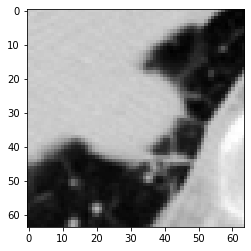

In [161]:
images = []
masks = []
annotation_indices = []
all_indices = []

for i, struct in enumerate(ds.as_numpy_iterator()):
    if i == 9:
        plt.imshow(struct['img'][15], cmap=plt.cm.gray)
        print(struct['scan_id'])
        print(struct['annotation_indices'])
        print(struct['img'].shape)
        print(struct['label'])
        print(struct['internalStructure'])
        print(struct['calcification'])
        print(struct['sphericity'])
        print(struct['margin'])
        print(struct['lobulation'])
        print(struct['spiculation'])
        print(struct['texture'])
        print("\n")
        break
    
#     img = struct['img']
#     print(struct)
#     print(np.unique(struct['img'][86]))
#     plt.imshow(zero_center(normalize(struct['img'][86])))
#     break

In [ ]:
scan_index = 1
display_scans(np.array(images[scan_index]), np.array(masks[scan_index]), list(annotation_indices[scan_index]), list(all_indices[scan_index]))